# FLAI_Net Training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Dataset

In [2]:
ds = pd.read_csv('../dataset/flai_data.csv')
ds = ds.sort_values('label')
ds.head()

,user,label,coordinate 0,coordinate 1,coordinate 2,coordinate 3,coordinate 4,coordinate 5,coordinate 6,coordinate 7,...,coordinate 53,coordinate 54,coordinate 55,coordinate 56,coordinate 57,coordinate 58,coordinate 59,coordinate 60,coordinate 61,coordinate 62
0,lea,a,0.699433,0.694308,-5.125001e-07,0.648201,0.623592,-0.013627,0.620721,0.537524,...,-0.021148,0.727923,0.482140,-0.033280,0.721847,0.531752,-0.020166,0.734710,0.541902,-0.006052
2055,Martin,a,0.755843,0.946230,-7.576355e-07,0.596653,0.829356,-0.110176,0.508049,0.659072,...,-0.162198,0.919824,0.336035,-0.268012,0.894528,0.449780,-0.275523,0.853873,0.497211,-0.263470
2054,Martin,a,0.448966,0.805226,-6.289455e-07,0.553169,0.762983,-0.027101,0.617719,0.629570,...,-0.031833,0.432160,0.389669,-0.056247,0.446245,0.467956,-0.039005,0.441467,0.513121,-0.018076
2053,Martin,a,0.642172,0.783267,-9.619788e-07,0.548792,0.735658,-0.047853,0.478785,0.619713,...,-0.012934,0.690963,0.380511,-0.038585,0.675585,0.456306,-0.021411,0.669445,0.498558,-0.000121
2052,Martin,a,0.712538,0.878059,-1.231915e-06,0.591809,0.799211,-0.057425,0.506353,0.622470,...,-0.024946,0.815513,0.338214,-0.068287,0.788838,0.439484,-0.054281,0.773832,0.491689,-0.031064


### Dataset Statistics

In [3]:
num_samples = len(ds)
num_contributors = len(pd.unique(ds.user))
classes = pd.unique(ds.label)
print(f'Samples: {num_samples}')
print(f'Unique contributors: {num_contributors}')
print(f'Classes: {classes}')

Samples: 7306
Unique contributors: 7
Classes: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y']


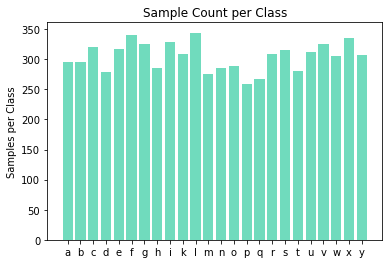

In [4]:
samples_per_label = ds.label.value_counts().sort_index()
color = (112/255, 219/255, 189/255)
x_pos = [i for i in range(len(samples_per_label.index))]
plt.bar(x_pos, samples_per_label, color=color)
plt.xticks(x_pos, samples_per_label.index)
plt.ylabel('Samples per Class')
plt.title('Sample Count per Class')
plt.show()

### Shuffle and Split Dataset

In [5]:
ds_y = ds.label.array
ds_y = pd.factorize(ds_y)[0]
ds_y = np.array(ds_y)

ds_x = ds.drop(['label', 'user'], axis=1)
ds_x = ds_x.to_numpy()

### Reshape Landmark Vectors

In [6]:
print(ds_y.shape)
print(ds_x.shape)

(7306,)
(7306, 63)


In [7]:
num_samples = ds_x.shape[0]
dim = 3
landmarks = 21
ds_x = ds_x.reshape((num_samples, landmarks, dim))
print(ds_x.shape)

(7306, 21, 3)


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.2, random_state=42)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5844, 21, 3)
(5844,)
(1462, 21, 3)
(1462,)


### Plot Vectors

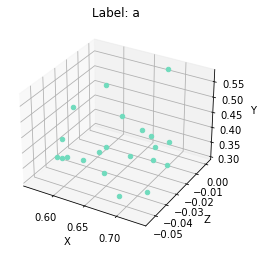

In [10]:
num = 10
example = ds_x[num]
label = ds_y[num]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for vec in example:
    ax.scatter(vec[0], vec[2], vec[1], c=[color])

plt.title(f'Label: {classes[label]}')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

## Train Neural Network

### Set Hyperparameters

In [11]:
epochs = 10
val_split = .2

### Labels to One Hot

In [12]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train.astype(int))
y_test = to_categorical(y_test.astype(int))

print(y_train.shape)
print(y_test.shape)

(5844, 24)
(1462, 24)


### Create Callbacks

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_acc',
                           restore_best_weights=True,
                           patience=10,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.2,
                              min_lr=0.00001,
                              patience=5,
                              verbose=1)

### Create Model

In [14]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, AlphaDropout, LayerNormalization

inputs = Input(shape=x_train[0].shape, name='Landmark_Vectors')

layerNorm = LayerNormalization(name='LayerNorm')(inputs)

flatten = Flatten(name='Flatten_Vectors')(layerNorm)

dense_count = 6
dense_base = 48
out = flatten

for i in range(dense_count):
    units = (dense_count-i) * (dense_count-i) * dense_base
    dense = Dense(units, 
                  kernel_initializer="lecun_normal", 
                  bias_initializer="zeros", 
                  activation='selu',
                  name=f'Dense_{i+1}')
    a_dropout = AlphaDropout(0.05, name=f'Dropout_{i+1}')
    out = dense(out)
    out = a_dropout(out)

outputs = Dense(y_train[0].shape[0], activation='softmax', name='Output_Vector')(out)
model = Model(inputs=inputs, outputs=outputs, name="Deep_Flai_6")
model.summary()

Model: "Deep_Flai_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Vectors (InputLaye  [(None, 21, 3)]          0         
 r)                                                              
                                                                 
 LayerNorm (LayerNormalizati  (None, 21, 3)            6         
 on)                                                             
                                                                 
 Flatten_Vectors (Flatten)   (None, 63)                0         
                                                                 
 Dense_1 (Dense)             (None, 1728)              110592    
                                                                 
 Dropout_1 (AlphaDropout)    (None, 1728)              0         
                                                                 
 Dense_2 (Dense)             (None, 1200)              

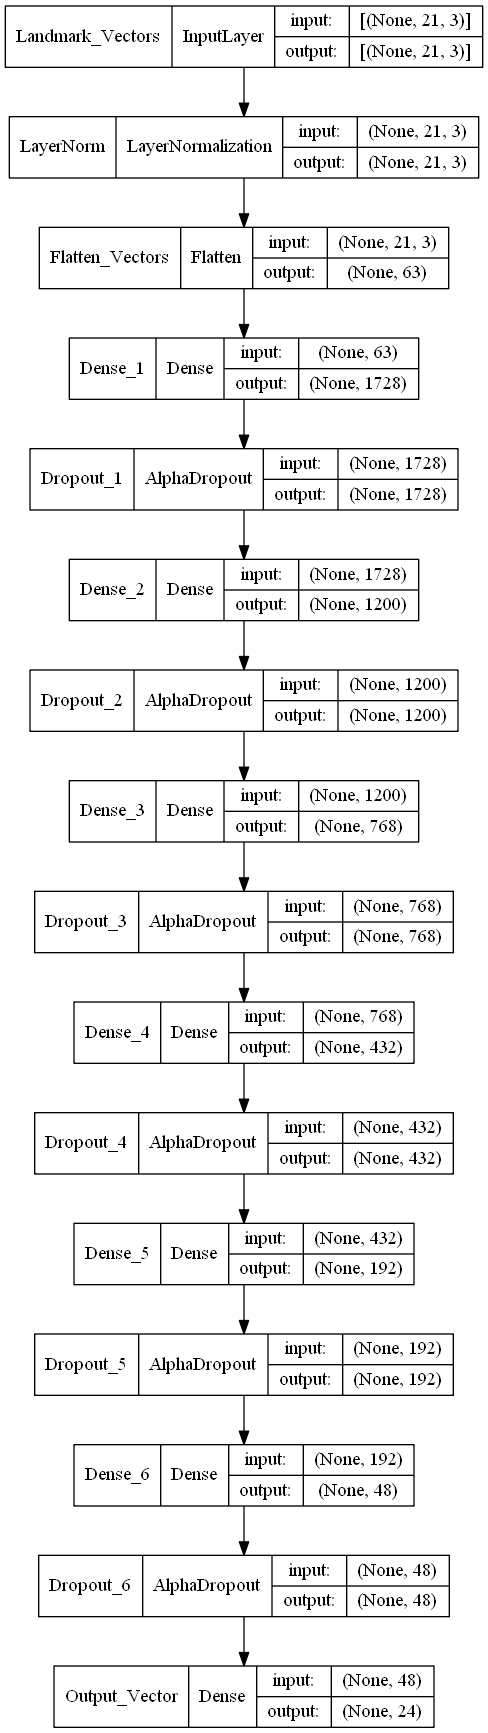

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, "flai_net.png", show_shapes=True)

### Train Model

In [15]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.001, beta_2=0.99, epsilon=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

history = model.fit(x_train, y_train,
                      epochs=100,
                      batch_size=32,
                      validation_split=val_split,
                      callbacks=[early_stop, reduce_lr])

Epoch 1/100
147/147 [==============================] - 8s 39ms/step - loss: 3.1510 - acc: 0.0995 - val_loss: 2.2988 - val_acc: 0.2703 - lr: 0.0010
Epoch 2/100
147/147 [==============================] - 6s 38ms/step - loss: 1.9680 - acc: 0.3260 - val_loss: 1.3679 - val_acc: 0.4927 - lr: 0.0010
Epoch 3/100
147/147 [==============================] - 8s 52ms/step - loss: 1.3645 - acc: 0.5010 - val_loss: 1.1497 - val_acc: 0.5877 - lr: 0.0010
Epoch 4/100
147/147 [==============================] - 7s 48ms/step - loss: 1.0522 - acc: 0.6090 - val_loss: 0.8319 - val_acc: 0.7032 - lr: 0.0010
Epoch 5/100
147/147 [==============================] - 6s 43ms/step - loss: 0.9241 - acc: 0.6449 - val_loss: 0.7646 - val_acc: 0.7254 - lr: 0.0010
Epoch 6/100
147/147 [==============================] - 6s 43ms/step - loss: 0.8078 - acc: 0.6937 - val_loss: 0.5861 - val_acc: 0.8067 - lr: 0.0010
Epoch 7/100
147/147 [==============================] - 6s 40ms/step - loss: 0.7629 - acc: 0.7080 - val_loss: 0.6104 - 

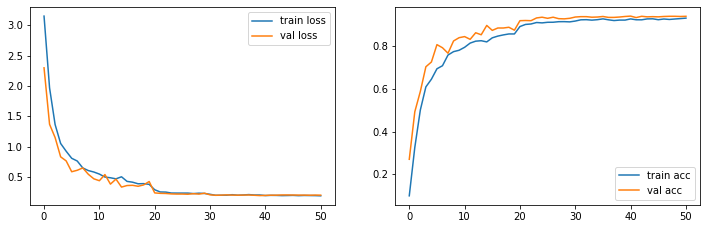

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()

### Save Model

In [17]:
model.save(f'{model.name}.h5')

## Store Variables

In [18]:
model_name = model.name
%store x_test
%store y_test
%store model_name
%store classes
del x_test
del y_test
del model_name
del classes

Stored 'x_test' (ndarray)
Stored 'y_test' (ndarray)
Stored 'model_name' (str)
Stored 'classes' (ndarray)
